In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [3]:
dataframe = pd.read_csv('kbo_18_24_merged.csv', encoding='cp949')
df = dataframe.copy()

# 파생변수
df['나이'] = df['연도'] - df['출생연도']
df['플레이오프'] = df['팀순위'].apply(lambda x: 1 if x <= 5 else 0)
df.head(3)

,연도,순위,선수명,팀명,AVG,G,PA,AB,R,H,...,팀패수,팀무승부수,팀승률,팀게임차,출생연도,투구유형,타격유형,포지션,나이,플레이오프
0,2018,9,유한준,KT,0.339,121,480,428,59,145,...,82,3,0.418,32.5,1981.0,우투,우타,외야수,37.0,0
1,2018,30,로하스,KT,0.305,144,645,564,114,172,...,82,3,0.418,32.5,1990.0,우투,양타,외야수,28.0,0
2,2018,29,호잉,한화,0.306,142,590,529,85,162,...,67,0,0.535,16.0,1989.0,우투,좌타,외야수,29.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   연도      383 non-null    int64  
 1   순위      383 non-null    int64  
 2   선수명     383 non-null    object 
 3   팀명      383 non-null    object 
 4   AVG     383 non-null    float64
 5   G       383 non-null    int64  
 6   PA      383 non-null    int64  
 7   AB      383 non-null    int64  
 8   R       383 non-null    int64  
 9   H       383 non-null    int64  
 10  2B      383 non-null    int64  
 11  3B      383 non-null    int64  
 12  HR      383 non-null    int64  
 13  TB      383 non-null    int64  
 14  RBI     383 non-null    int64  
 15  SAC     383 non-null    int64  
 16  SF      383 non-null    int64  
 17  BB      383 non-null    int64  
 18  IBB     383 non-null    int64  
 19  HBP     383 non-null    int64  
 20  SO      383 non-null    int64  
 21  GDP     383 non-null    int64  
 22  SL

In [5]:
df.isna().sum() # 결측치 없음

연도        0
순위        0
선수명       0
팀명        0
AVG       0
G         0
PA        0
AB        0
R         0
H         0
2B        0
3B        0
HR        0
TB        0
RBI       0
SAC       0
SF        0
BB        0
IBB       0
HBP       0
SO        0
GDP       0
SLG       0
OBP       0
OPS       0
MH        0
RISP      0
PH-BA     0
XBH       0
GO        0
AO        0
GO/AO     0
GW RBI    0
BB/K      0
P/PA      0
ISOP      0
XR        0
GPA       0
팀순위       0
경기수       0
팀승수       0
팀패수       0
팀무승부수     0
팀승률       0
팀게임차      0
출생연도      0
투구유형      0
타격유형      0
포지션       0
나이        0
플레이오프     0
dtype: int64

In [6]:
df.columns

Index(['연도', '순위', '선수명', '팀명', 'AVG', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'TB', 'RBI', 'SAC', 'SF', 'BB', 'IBB', 'HBP', 'SO', 'GDP', 'SLG',
       'OBP', 'OPS', 'MH', 'RISP', 'PH-BA', 'XBH', 'GO', 'AO', 'GO/AO',
       'GW RBI', 'BB/K', 'P/PA', 'ISOP', 'XR', 'GPA', '팀순위', '경기수', '팀승수',
       '팀패수', '팀무승부수', '팀승률', '팀게임차', '출생연도', '투구유형', '타격유형', '포지션', '나이',
       '플레이오프'],
      dtype='object')

### 모델링: 멀티태스크 모델
1. 다중 클래스 분류: 1~10위 순위 예측  
2. 이진 분류: 플레이오프 진출 여부 예측(T/F)

#### 1. 타겟 변수 생성

In [7]:
# 멀티태스크용 타겟
df['rank_target'] = df['팀순위'].astype('category')            # 다중 클래스
df['playoff_target'] = df['플레이오프'].astype('category')     # 이진 클래스

In [8]:
df[['rank_target','playoff_target']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   rank_target     383 non-null    category
 1   playoff_target  383 non-null    category
dtypes: category(2)
memory usage: 1.4 KB


#### 2. 변수 선택

In [9]:
# 포함되면 안되는 정보:
leakage_cols = [
    '팀순위', '순위', '선수명', '팀명',
    '팀승수', '팀패수', '팀무승부수', '팀승률', '팀게임차', '출생연도',
    'rank_target', 'playoff_target', '플레이오프'
]

# 시간 구분용: 학습 피처에서는 제외
meta_cols = ['연도']  

# 학습에 활용할 변수 생성
drop_cols = leakage_cols + meta_cols
feature_cols = [col for col in df.columns if col not in drop_cols]

#### 3. train/test split

In [12]:
train_df = df[df['연도'].isin([2018,2019,2020,2021, 2022])]
test_df = df[df['연도'].isin([2023,2024])].copy()

print(test_df.연도.unique())

[2023 2024]


#### 4. X, y 분리

In [13]:
X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

y_train_rank = train_df['rank_target']
y_test_rank = test_df['rank_target']

y_train_playoff = train_df['playoff_target']
y_test_playoff = test_df['playoff_target']

#### 5. 범주형 변수 전처리

In [14]:
# 범주형 변수 자동 탐지
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

# One-hot 인코딩 적용: 트리 기반 모델링을 진행하기에 drop_first는 생략
X_train = pd.get_dummies(X_train, columns=cat_cols)
X_test = pd.get_dummies(X_test, columns=cat_cols)

# train/test 컬럼 일치시키기
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [15]:
y_train_playoff.value_counts() # 불균형이라 볼 수 없음.

playoff_target
1    151
0    126
Name: count, dtype: int64

#### 6. 모델 학습 및 예측

In [16]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

##### 1) Random Forest

In [17]:
# (1) 순위 예측 (다중 클래스)
rf_rank = RandomForestClassifier(random_state=42)
rf_rank.fit(X_train, y_train_rank)
rf_rank_preds = rf_rank.predict(X_test)

# (2) 플레이오프 예측 (이진 분류)
# rf_playoff = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_playoff = RandomForestClassifier(random_state=42)
rf_playoff.fit(X_train, y_train_playoff)
rf_playoff_preds = rf_playoff.predict(X_test)

##### 2) XGBoost

In [18]:
# softmax는 0부터 시작해야함
y_train_rank_xgb = y_train_rank.astype(int) - 1
y_test_rank_xgb = y_test_rank.astype(int) - 1

In [19]:
# (1) 순위 예측 (다중 클래스)
xgb_rank = XGBClassifier(objective='multi:softmax', num_class=10, eval_metric='mlogloss', random_state=42)
xgb_rank.fit(X_train, y_train_rank_xgb)
xgb_rank_preds = xgb_rank.predict(X_test)
xgb_rank_preds += 1 # 예측 결과 복원 (0~9 => 1~10)


# (2) 플레이오프 예측 (이진 분류)
# imbalance_ratio = (y_train_playoff == 0).sum() / (y_train_playoff == 1).sum() # 불균형 비율
# xgb_playoff = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=imbalance_ratio, random_state=42)
xgb_playoff = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)
xgb_playoff.fit(X_train, y_train_playoff)
xgb_playoff_preds = xgb_playoff.predict(X_test)

##### 3) lightGBM

In [20]:
# (1) 순위 예측 (다중 클래스)
lgbm_rank = LGBMClassifier(objective='multiclass', num_class=10, metric='multi_logloss', random_state=42)
lgbm_rank.fit(X_train, y_train_rank)
lgbm_rank_preds = lgbm_rank.predict(X_test)

# (2) 플레이오프 예측 (이진 분류)
# lgbm_playoff = LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced', random_state=42)
lgbm_playoff = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
lgbm_playoff.fit(X_train, y_train_playoff)
lgbm_playoff_preds = lgbm_playoff.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1805
[LightGBM] [Info] Number of data points in the train set: 277, number of used features: 41
[LightGBM] [Info] Start training from score -2.127510
[LightGBM] [Info] Start training from score -2.040499
[LightGBM] [Info] Start training from score -2.291813
[LightGBM] [Info] Start training from score -2.291813
[LightGBM] [Info] Start training from score -2.365921
[LightGBM] [Info] Start training from score -2.222820
[LightGBM] [Info] Start training from score -2.488523
[LightGBM] [Info] Start training from score -2.256722
[LightGBM] [Info] Start training from score -2.328181
[LightGBM] [Info] Start training from score -2.790804
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

#### 7. 기본 모델 평가

In [21]:
def evaluate_model(name, y_true, y_pred, average_type='macro'):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average_type)
    print(f"{name:<25} | Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")
    return [name, acc, f1]


In [22]:
results = []
results.append(evaluate_model("RF - 팀순위", y_test_rank, rf_rank_preds))
results.append(evaluate_model("XGB - 팀순위", y_test_rank, xgb_rank_preds))
results.append(evaluate_model("LGBM - 팀순위", y_test_rank, lgbm_rank_preds))
results.append(evaluate_model("RF - 플레이오프", y_test_playoff, rf_playoff_preds))
results.append(evaluate_model("XGB - 플레이오프", y_test_playoff, xgb_playoff_preds))
results.append(evaluate_model("LGBM - 플레이오프", y_test_playoff, lgbm_playoff_preds))

results_df = pd.DataFrame(results, columns=["모델", "Accuracy", "F1"])
results_df

RF - 팀순위                  | Accuracy: 0.0849 | F1 Score: 0.0746
XGB - 팀순위                 | Accuracy: 0.0849 | F1 Score: 0.0742
LGBM - 팀순위                | Accuracy: 0.0943 | F1 Score: 0.0745
RF - 플레이오프                | Accuracy: 0.5660 | F1 Score: 0.5500
XGB - 플레이오프               | Accuracy: 0.5943 | F1 Score: 0.5809
LGBM - 플레이오프              | Accuracy: 0.5566 | F1 Score: 0.5385


,모델,Accuracy,F1
0,RF - 팀순위,0.084906,0.074645
1,XGB - 팀순위,0.084906,0.074160
2,LGBM - 팀순위,0.094340,0.074507
3,RF - 플레이오프,0.566038,0.550018
4,XGB - 플레이오프,0.594340,0.580874
5,LGBM - 플레이오프,0.556604,0.538490


#### 8. 모델 디벨롭

In [23]:
from sklearn.model_selection import GridSearchCV

##### 1) Random Forest

In [24]:
# 파라미터 그리드 정의
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_clf = RandomForestClassifier(random_state=42)
# rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_rf = GridSearchCV(rf_clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# 이진 분류용 플레이오프 타겟에 대해 튜닝
grid_rf.fit(X_train, y_train_playoff)

print("Best Parameters:", grid_rf.best_params_)
print("Best F1 Score:", grid_rf.best_score_.round(4))


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 Score: 0.6787


##### 2) XGBoost

In [25]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
# xgb_clf = XGBClassifier(objective='binary:logistic', eval_metric='logloss', scale_pos_weight=imbalance_ratio, use_label_encoder=False, random_state=42)
grid_xgb = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train_playoff)

print("XGB Best Params:", grid_xgb.best_params_)
print("XGB Best F1:", grid_xgb.best_score_.round(4))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
XGB Best Params: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300}
XGB Best F1: 0.666


c:\Users\wjdtj\anaconda3\envs\jsy\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


##### 3) LightGBM

In [26]:
# 하이퍼파라미터 후보군 설정
param_grid_lgbm = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'min_child_samples': [10, 20, 30]
}

# 모델 정의
lgbm_clf = LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42)
# lgbm_clf = LGBMClassifier(objective='binary', metric='binary_logloss', class_weight='balanced', random_state=42)

# GridSearchCV 실행
grid_lgbm = GridSearchCV(estimator=lgbm_clf, param_grid=param_grid_lgbm, scoring='f1', cv=3, verbose=1, n_jobs=-1)

# 학습
grid_lgbm.fit(X_train, y_train_playoff)

# 결과 출력
print("Best Parameters:", grid_lgbm.best_params_)
print("Best F1 Score:", grid_lgbm.best_score_.round(4))

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1801
[LightGBM] [Info] Number of data points in the train set: 277, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545126 -> initscore=0.180998
[LightGBM] [Info] Start training from score 0.180998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

#### 9. 최종 모델 선정 및 성능 평가

In [29]:
# 1. 최적 모델들 꺼내오기
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_lgbm = grid_lgbm.best_estimator_

# 2. 각 모델별 예측 수행
rf_final_preds = best_rf.predict(X_test)
xgb_final_preds = best_xgb.predict(X_test)
lgbm_final_preds = best_lgbm.predict(X_test)

# 3. 평가 함수 정의
def print_metrics(name, y_true, y_pred):
    print(f"\n모델명: [{name}]")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1 Score:", round(f1_score(y_true, y_pred), 4))
    print("Classification Report:\n", classification_report(y_true, y_pred))

# 4. 모델별 평가 결과 출력
print_metrics("Random Forest", y_test_playoff, rf_final_preds)
print_metrics("XGBoost", y_test_playoff, xgb_final_preds)
print_metrics("LightGBM", y_test_playoff, lgbm_final_preds)


모델명: [Random Forest]
Accuracy: 0.5755
F1 Score: 0.6715
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.34      0.40        44
           1       0.61      0.74      0.67        62

    accuracy                           0.58       106
   macro avg       0.55      0.54      0.54       106
weighted avg       0.56      0.58      0.56       106


모델명: [XGBoost]
Accuracy: 0.6132
F1 Score: 0.672
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53        44
           1       0.67      0.68      0.67        62

    accuracy                           0.61       106
   macro avg       0.60      0.60      0.60       106
weighted avg       0.61      0.61      0.61       106


모델명: [LightGBM]
Accuracy: 0.5755
F1 Score: 0.6715
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.34      0.40        44
         

In [30]:
print(y_test_playoff.to_list())
print('-'*50)
print(xgb_playoff_preds.tolist())

[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0]
--------------------------------------------------
[1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]


=> 데이터 불균형 문제도 151:126로 거의 존재하지 않는다 판단하였음.  

**[모델 성능]**  
Accuracy가 낮으나, XGBoost에서 가장 뛰어난 성능을 보였으며,  
플레이오프에 진출하는 팀에 대해 가장 잘 맞추었음.  

##### 9.1) Threshold 최적화 기반 재평가(XGBoost에 대해서)

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
# 1. XGBoost 확률 예측
xgb_playoff_proba = best_xgb.predict_proba(X_test)[:, 1]  # class 1 확률만

# 2. threshold 튜닝 함수 정의
def optimize_threshold_macro_f1(y_true, y_proba):
    best_threshold = 0.5
    best_macro_f1 = 0
    for thresh in np.arange(0.1, 0.9, 0.01):
        preds = (y_proba >= thresh).astype(int)
        macro_f1 = f1_score(y_true, preds, average='macro')  # 핵심 수정 부분
        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_threshold = thresh
    return best_threshold, best_macro_f1

# 3. 최적 threshold 계산
best_thresh, best_f1 = optimize_threshold_macro_f1(y_test_playoff, xgb_playoff_proba)
print(f"최적 Threshold: {round(best_thresh, 2)}, F1 Score: {round(best_f1, 4)}")

# 4. 최적 threshold로 재예측 및 평가
xgb_thresh_preds = (xgb_playoff_proba >= best_thresh).astype(int)

print("\n [XGBoost - Threshold 최적화 적용 결과]")
print("Accuracy:", round(accuracy_score(y_test_playoff, xgb_thresh_preds), 4))
print("F1 Score:", round(f1_score(y_test_playoff, xgb_thresh_preds), 4))
print("Classification Report:\n", classification_report(y_test_playoff, xgb_thresh_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test_playoff, xgb_thresh_preds))


최적 Threshold: 0.49, F1 Score: 0.6004

 [XGBoost - Threshold 최적화 적용 결과]
Accuracy: 0.6132
F1 Score: 0.672
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53        44
           1       0.67      0.68      0.67        62

    accuracy                           0.61       106
   macro avg       0.60      0.60      0.60       106
weighted avg       0.61      0.61      0.61       106

Confusion Matrix:
 [[23 21]
 [20 42]]


최적의 threshold가 0.49이나  
마찬가지로 영향력은 미비함.

#### 10. Explaning Model: 변수의 영향력 설명
- Feature Importance: 변수 중요도, 모델의 성능에 영향을 미친 정도
- SHAP: Y 값을 예측하는데 변수가 작용한 힘을 제시 

In [31]:
from xgboost import plot_importance
import shap

##### 1) Feature Importance

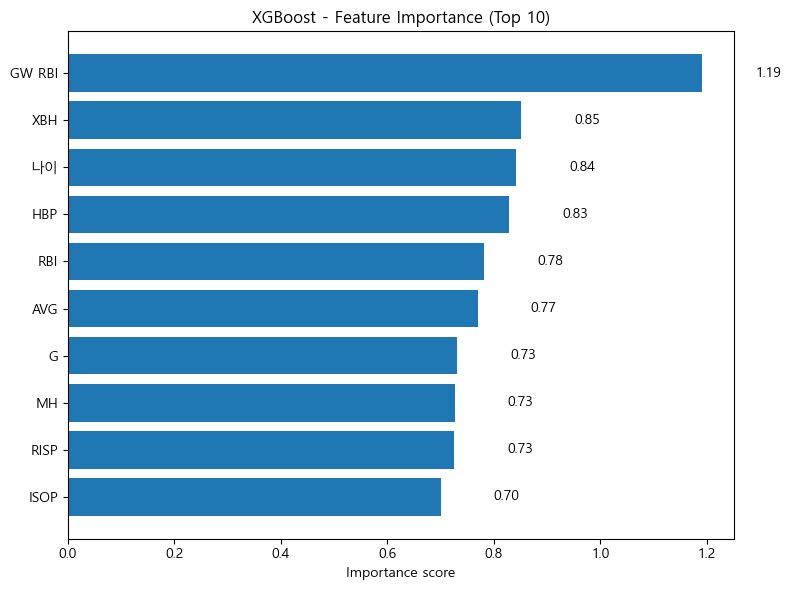

In [32]:
# 중요도 얻기
importance_df = best_xgb.get_booster().get_score(importance_type='gain')
importance_df = sorted(importance_df.items(), key=lambda x: x[1], reverse=True)[:10]

# 변수와 중요도 분리
features = [f[0] for f in importance_df]
scores = [f[1] for f in importance_df]

# 시각화
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(features)), scores, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance score')
plt.title("XGBoost - Feature Importance (Top 10)")

# 소수점 2자리로 수치 표시
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f"{scores[i]:.2f}", va='center')

plt.gca().invert_yaxis()  # 상위 중요도가 위로 오도록
plt.tight_layout()
plt.show()

결승타점(GW RBI)와 장타수(XBH), 나이 등이 모델의 성능에 가장 큰 영향을 미침.  
병살타를 치지않고 결정력이 있는 선수가 승패를 좌우함.

##### 2) SHAP

In [33]:
# SHAP 값 계산
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

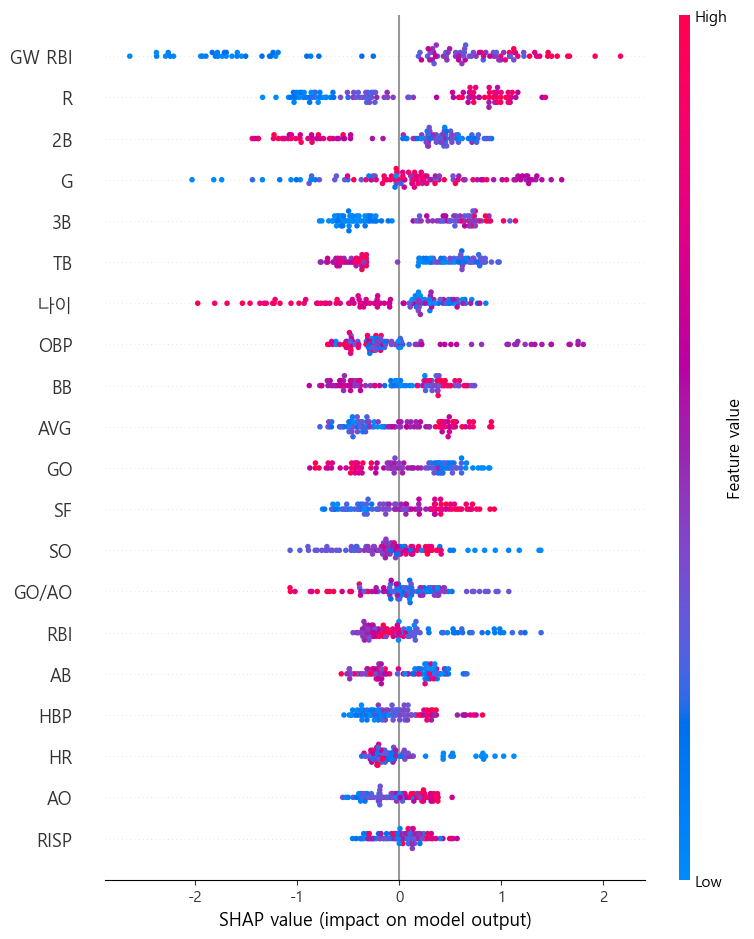

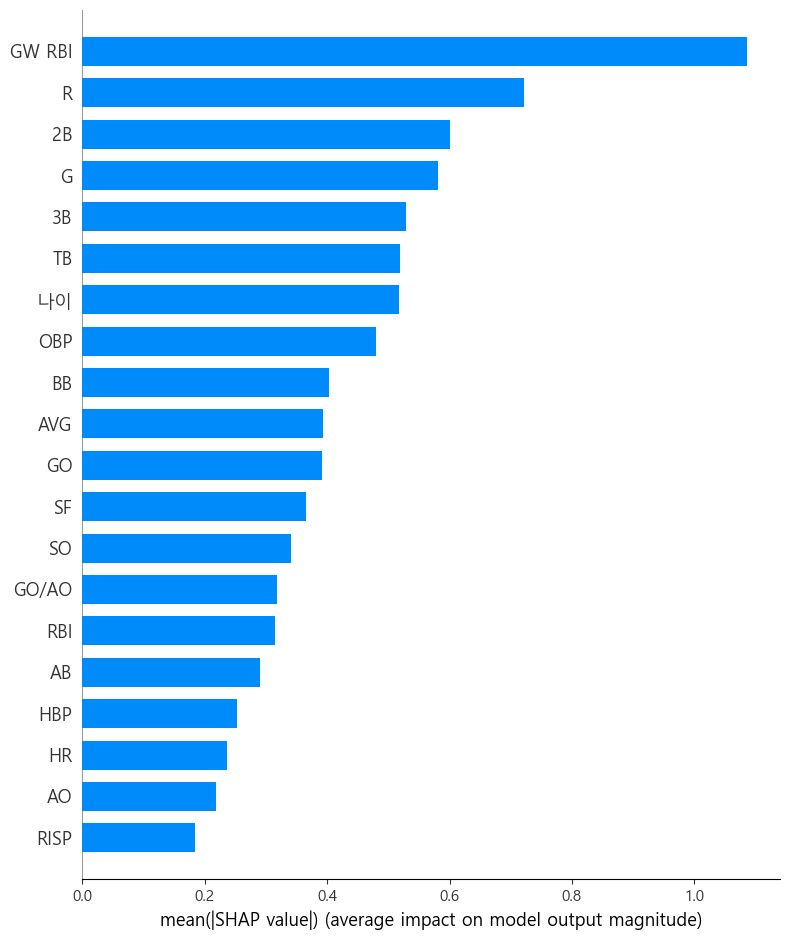

In [34]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

전반적인 설명 모델에 기반하여 확인해 보았을때,  
1. GW RBI: 결승타수  
2. R: 득점점  
3. 2B: 2루타  
이 중요한 변수로 작용하였다.  

최대한 결정력이 있는 선수가 플레이오프 진출 여부에 크게 영향을 미치고  
득점과 2루타와 같이 승리와 패베에 큰 영향을 미치는 타격지표가 영향력이 강함을 알 수 있음.